## Exploratory Analysis

In [1]:
#import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import pickle
import pandas as pd
import seaborn

%matplotlib inline

In [31]:
path = './audio/'
instruments = os.listdir('./audio/')
instruments

['bass_acoustic',
 'bass_electronic',
 'bass_synthetic',
 'brass_acoustic',
 'brass_electronic',
 'brass_synthetic',
 'flute_acoustic',
 'flute_electronic',
 'flute_synthetic',
 'guitar_acoustic',
 'guitar_electronic',
 'guitar_synthetic',
 'keyboard_acoustic',
 'keyboard_electronic',
 'keyboard_synthetic',
 'mallet_acoustic',
 'mallet_electronic',
 'mallet_synthetic',
 'organ_acoustic',
 'organ_electronic',
 'organ_synthetic',
 'reed_acoustic',
 'reed_electronic',
 'reed_synthetic',
 'string_acoustic',
 'string_electronic',
 'string_synthetic',
 'synth_lead_acoustic',
 'synth_lead_electronic',
 'synth_lead_synthetic',
 'vocal_acoustic',
 'vocal_electronic',
 'vocal_synthetic']

## Spectrogram

In [53]:
def read_audio_spectrum(filename, N_FFT = 2048, sr = None): #Short-time Fourier transform (STFT)
    x, fs = librosa.load(filename, sr=None)
    S = librosa.stft(x, N_FFT)
    #if x.ndim == 1:
        #x = np.expand_dims(x, 0)
    p = np.angle(S)
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

## Mel-frequency cepstral coefficients (MFCCs) 

In [4]:
def get_features(filename):
    y, sr = librosa.load(filename, sr=None)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20) #13 
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

## Getting samples

In [12]:
S_store = []
Mel_store = []
train_labels = []
for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/train') #lift all the files in the path
    for inst_path in instrument_path:
        train_labels.append(instrument)
        S, fs = read_audio_spectrum(path+instrument+'/train/'+inst_path)
        M = get_features(path+instrument+'/train/'+inst_path)
        S_store.append(S)
        Mel_store.append(M)

In [13]:
#Saving the matrix
with open('./Matrix/Spectrum_matrix', 'wb') as write:
    pickle.dump(S_store, write)
    write.close()
with open('./Matrix/MFCC_matrix', 'wb') as write:
    pickle.dump(Mel_store, write)
    write.close()
with open('./Matrix/train_labels', 'wb') as write:
    pickle.dump(train_labels, write)
    write.close()

In [6]:
#Loading the matrix
with open ('./Matrix/Spectrum_matrix', 'rb') as read:
    S_store = pickle.load(read)
with open ('./Matrix/MFCC_matrix', 'rb') as read:
    Mel_store = pickle.load(read)
with open ('./Matrix/train_labels', 'rb') as read:
    train_labels = pickle.load(read)    

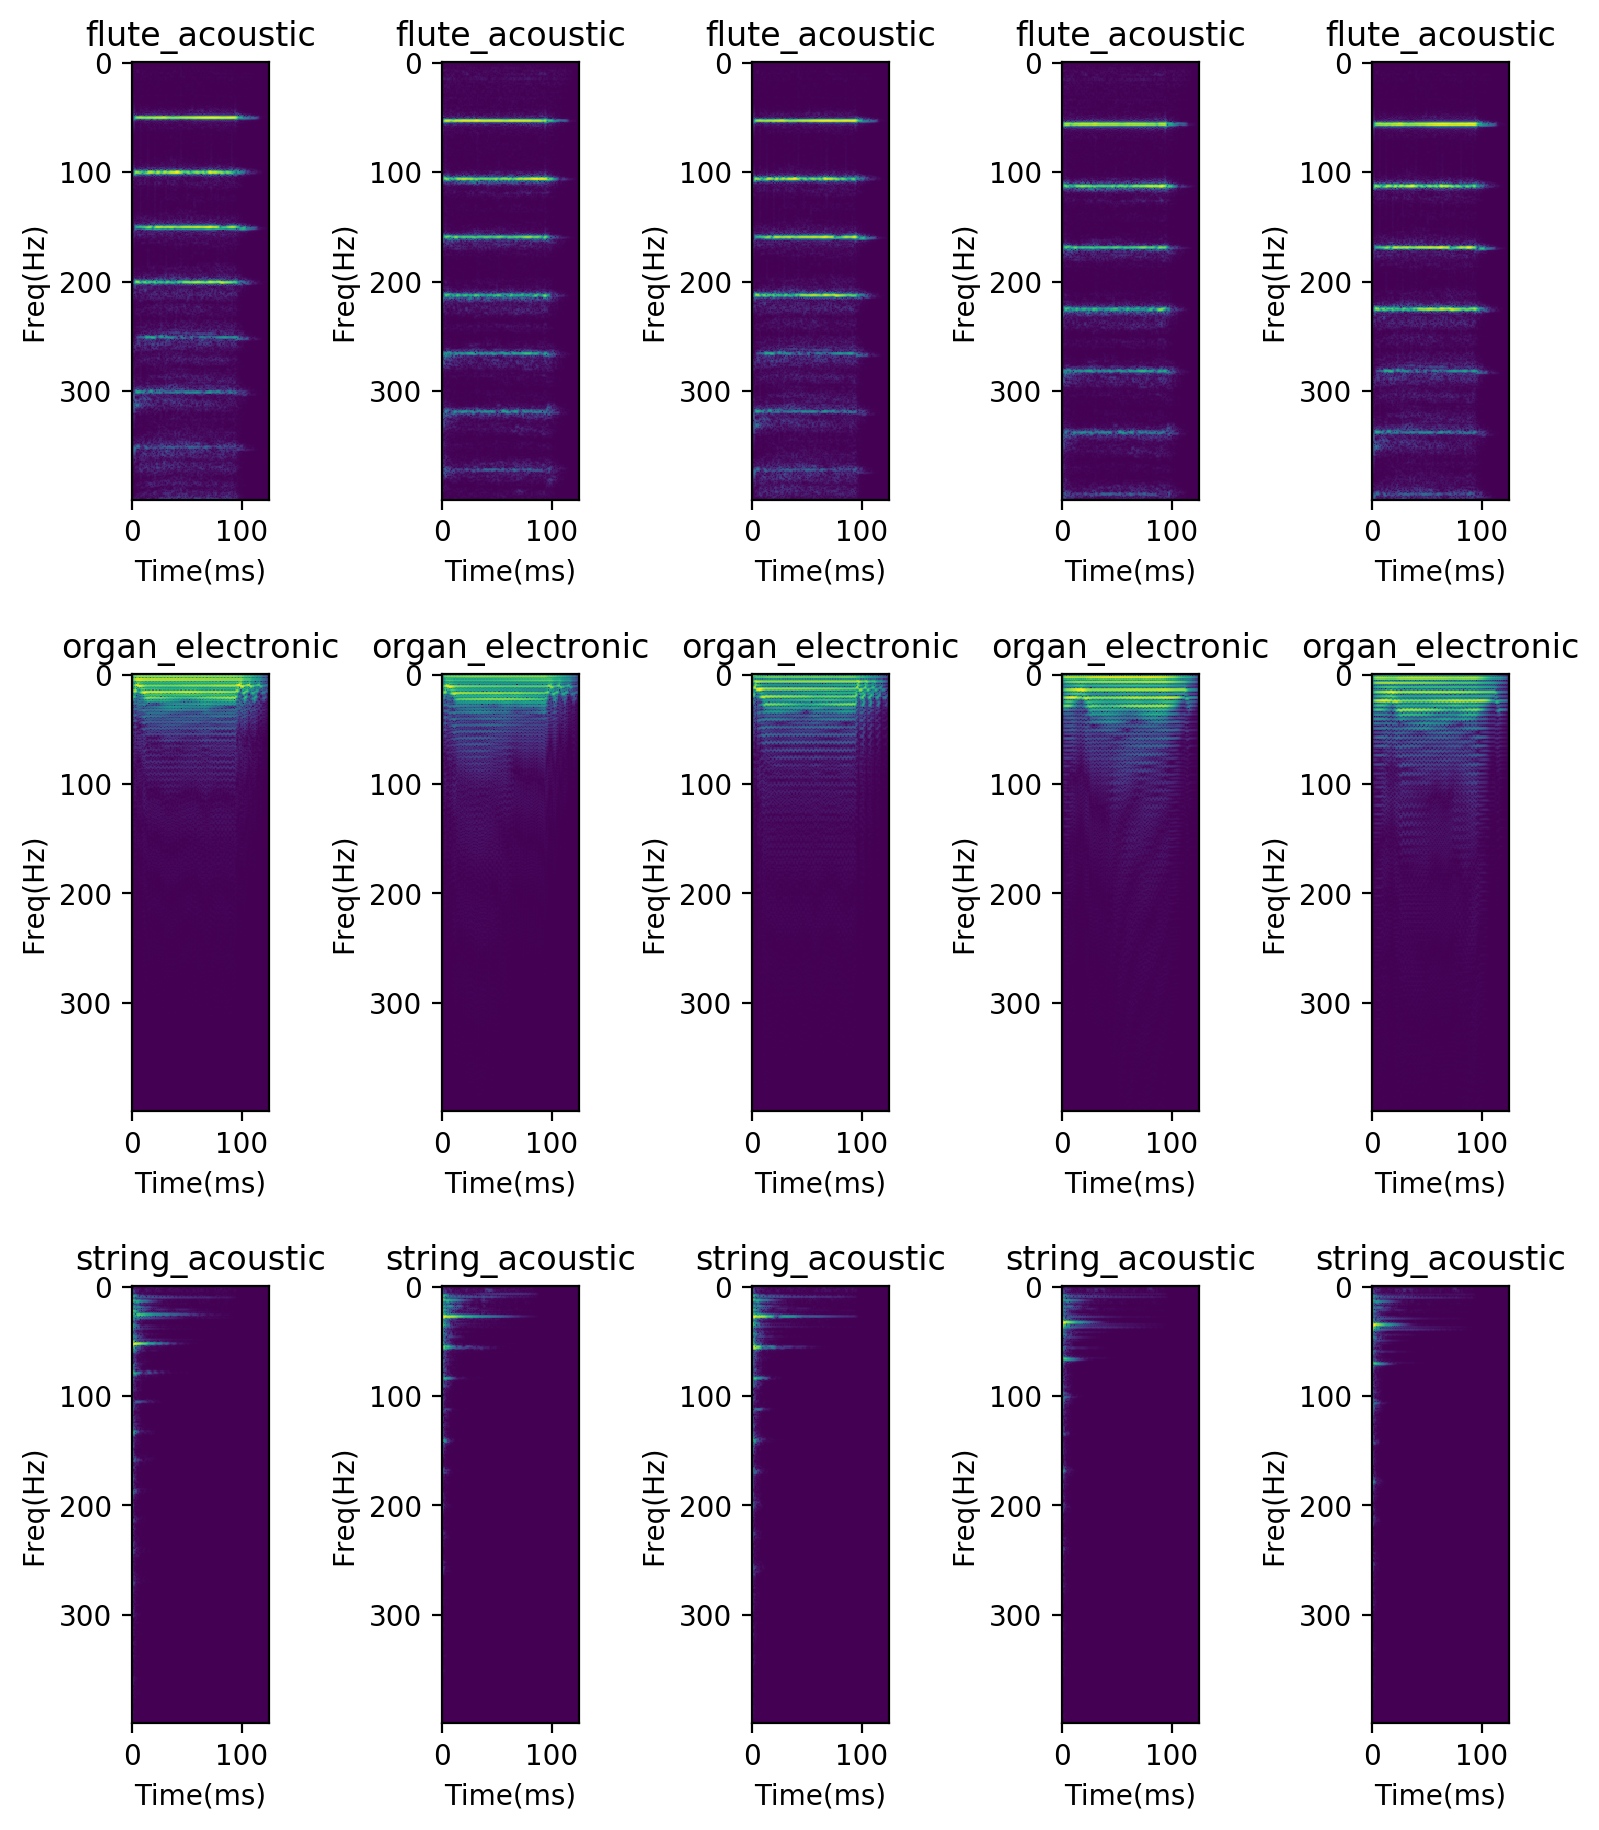

In [15]:
#Ploting the spectrums 
plt.figure(figsize=(10, 11), dpi=200)

for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.title(train_labels[i])
    plt.imshow(S_store[i][:400,:]) #400 is tha maximum frequency range we want to plot. The matrix goes from 0 to 1000
    plt.ylabel('Freq(Hz)')
    plt.xlabel('Time(ms)')

    plt.subplot(3, 5, i+6)
    plt.title(train_labels[i+150])
    plt.imshow(S_store[i+150][:400,:])
    plt.ylabel('Freq(Hz)')
    plt.xlabel('Time(ms)')
    
    plt.subplot(3, 5, i+11)
    plt.title(train_labels[i+400])
    plt.imshow(S_store[i+400][:400,:])
    plt.ylabel('Freq(Hz)')
    plt.xlabel('Time(ms)')
plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()

## Getting test features

In [16]:
S_store_test = []
Mel_store_test = []
test_labels = []
for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/test') #lift all the files in the path
    for inst_path in instrument_path:
        test_labels.append(instrument)
        S, fs = read_audio_spectrum(path+instrument+'/test/'+inst_path)
        M = get_features(path+instrument+'/test/'+inst_path)
        S_store_test.append(S)
        Mel_store_test.append(M) 

In [17]:
#Saving the matrix
with open('./Matrix/Spectrum_matrix_test', 'wb') as write:
    pickle.dump(S_store_test, write)
with open('./Matrix/MFCC_matrix_test', 'wb') as write:
    pickle.dump(Mel_store_test, write)
with open('./Matrix/test_labels', 'wb') as write:
    pickle.dump(test_labels, write)    

In [11]:
#Loading the matrix
with open ('./Matrix/Spectrum_matrix_test', 'rb') as read:
    S_store_test = pickle.load(read)
with open ('./Matrix/MFCC_matrix_test', 'rb') as read:
    Mel_store_test = pickle.load(read)
with open ('./Matrix/test_labels', 'rb') as read:
    test_labels = pickle.load(read)    

# Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score,f1_score,roc_curve,auc,precision_recall_curve,average_precision_score,confusion_matrix

#### MFCC

In [50]:
train_features = np.zeros((len(Mel_store),len(Mel_store[0])))
for n,i in enumerate(Mel_store):
    train_features[n] = i

test_features = np.zeros((len(Mel_store_test),len(Mel_store_test[0])))
for n,i in enumerate(Mel_store_test):
    test_features[n] = i

In [51]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 10, oob_score= True) #min_impurity_decrease maybe too?
rf.fit(train_features, train_labels)
#Test classification
classif_predictions = rf.predict(test_features)   
classi_probe = rf.predict_proba(test_features)  
rf_test_accuracy_mfcc= accuracy_score(test_labels,classif_predictions,normalize=True)
#Training classification
train_classif_predictions = rf.predict(train_features)  
rf_train_accuracy_mfcc = accuracy_score(train_labels,train_classif_predictions,normalize=True)
print('Accuracy clasification Training = %.3f' % rf_train_accuracy_mfcc)

f1 = f1_score(test_labels, classif_predictions, average='weighted') #Use labeled y-hat. Given that our classes present imbalance, we are going to use the weighted option;
print('Accuracy clasification Test = %.3f' % rf_test_accuracy_mfcc)
print('F1 score = %.3f' % f1)
print('OOB score = %.3f' %rf.oob_score_)

Accuracy clasification Training = 1.000
Accuracy clasification Test = 0.889
F1 score = 0.889
OOB score = 0.875


In [26]:
#Saving the Random Forest model in a binary file
with open('./classifiers//RF_MFCC', 'wb') as write:
    pickle.dump(rf, write)

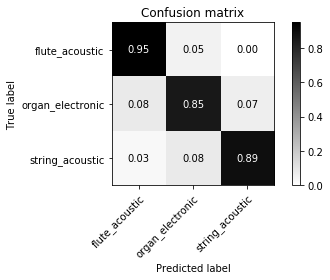

In [27]:
#Confusion matrix for multilevel classes
cm = confusion_matrix(test_labels, classif_predictions ,  labels=[inst for inst in instruments]) #use instruments
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = unique_labels(test_labels, classif_predictions)
cmap=plt.cm.gray_r
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=  'Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

#### Spectrum

In [44]:
train_features = np.array(S_store)
train_features = train_features.reshape(train_features.shape[0],-1)

test_features = np.array(S_store_test)
test_features = test_features.reshape(test_features.shape[0],-1)

In [49]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 10, oob_score= True) #min_impurity_decrease maybe too?
rf.fit(train_features, train_labels)
classif_predictions = rf.predict(test_features) 
#Predict test
classi_probe = rf.predict_proba(test_features)  
rf_test_accuracy_spectrum = accuracy_score(test_labels,classif_predictions,normalize=True)
#Predict Training
train_classif_predictions = rf.predict(train_features)  
rf_train_accuracy_spectrum = accuracy_score(train_labels,train_classif_predictions,normalize=True)

print('Accuracy clasification Training = %.3f' % rf_train_accuracy_spectrum)
f1 = f1_score(test_labels, classif_predictions, average='weighted') #Use labeled y-hat. Given that our classes present imbalance, we are going to use the weighted option;
print('Accuracy clasification Test = %.3f' % rf_test_accuracy_spectrum)
print('F1 score = %.3f' % f1)
print('OOB score = %.3f' %rf.oob_score_)
with open('./classifiers//RF_spectrum', 'wb') as write:
    pickle.dump(rf, write)

In [305]:
#Loading
with open ('./classifiers/RF_spectrum', 'rb') as read:
    rf = pickle.load(read) 
    read.close()

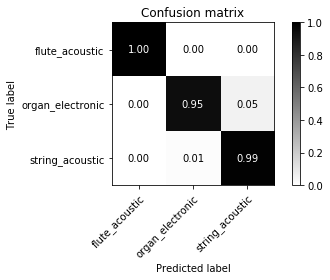

In [30]:
#Confusion matrix for multilevel classes
cm = confusion_matrix(test_labels, classif_predictions ,  labels=[inst for inst in instruments]) #use instruments
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = unique_labels(test_labels, classif_predictions)
cmap=plt.cm.gray_r
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=  'Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

# XG - Bosting

### MFCC

In [30]:
train_features = np.zeros((len(Mel_store),len(Mel_store[0])))
for n,i in enumerate(Mel_store):
    train_features[n] = i

test_features = np.zeros((len(Mel_store_test),len(Mel_store_test[0])))
for n,i in enumerate(Mel_store_test):
    test_features[n] = i

In [31]:
import xgboost as xgb
from sklearn.model_selection import cross_validate, train_test_split

XG = xgb.XGBClassifier(max_depth=3, booster='gbtree', n_estimators=200, learning_rate=0.1)
XG.fit(train_features, train_labels)
#Predict Training
train_classif_predictions = XG.predict(train_features)  
xg_train_accuracy_mfcc = accuracy_score(train_labels,train_classif_predictions,normalize=True)
print('Accuracy clasification Training = %.3f' % xg_train_accuracy_mfcc)
#Predicting Testing
classif_predictions = XG.predict(test_features)
xg_accuracy_mfcc= accuracy_score(test_labels, classif_predictions,normalize=True)
print('Accuracy clasification Testing = %.3f' %  xg_accuracy_mfcc )

#Save model
with open('./classifiers/XG_mfcc', 'wb') as write:
    pickle.dump(XG, write)

Accuracy clasification Training = 1.000
Accuracy clasification Testing = 0.910


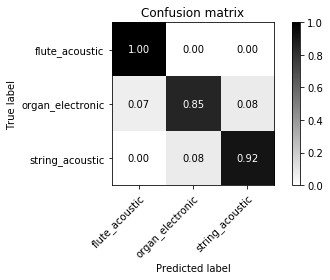

In [32]:
#Confusion matrix for multilevel classes
cm = confusion_matrix(test_labels, classif_predictions ,  labels=[inst for inst in instruments]) #use instruments
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = unique_labels(test_labels, classif_predictions)
cmap=plt.cm.gray_r
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=  'Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

## Spectrum

In [34]:
train_features = np.array(S_store)
train_features = train_features.reshape(train_features.shape[0],-1)
test_features = np.array(S_store_test)
test_features = test_features.reshape(test_features.shape[0],-1)

In [26]:
import xgboost as xgb
from sklearn.model_selection import cross_validate, train_test_split
XG = xgb.XGBClassifier(max_depth=3, booster='gbtree', n_estimators=200, learning_rate=0.1)
XG.fit(train_features, train_labels)
#Save model
with open('./classifiers/XG_spectrum', 'wb') as write:
    pickle.dump(XG, write)
    
#Predict Training
train_classif_predictions = XG.predict(train_features)  
xg_train_accuracy_spectrum = accuracy_score(train_labels,train_classif_predictions,normalize=True)
print('Accuracy clasification Training = %.3f' % xg_train_accuracy_spectrum)

#Predicting Testing
classif_predictions = XG.predict(test_features)
xg_accuracy_spectrum= accuracy_score(test_labels, classif_predictions,normalize=True)
print('Accuracy clasification Testing = %.3f' %  xg_accuracy_spectrum)

Accuracy clasification Training = 1.000
Accuracy clasification Testing = 0.979


In [304]:
#Loading
with open ('./classifiers/XG_spectrum', 'rb') as read:
    XG = pickle.load(read) 
    read.close()

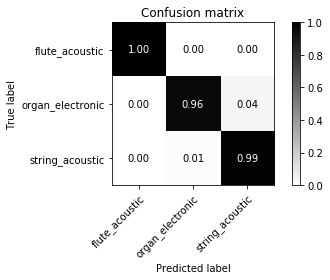

In [36]:
#Confusion matrix for multilevel classes
cm = confusion_matrix(test_labels, classif_predictions ,  labels=[inst for inst in instruments]) #use instruments
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = unique_labels(test_labels, classif_predictions)
cmap=plt.cm.gray_r
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=  'Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

In [229]:
acc = pd.DataFrame( data= {'Accuracy' : [rf_train_accuracy_mfcc,rf_test_accuracy_mfcc,
             rf_train_accuracy_spectrum,rf_test_accuracy_spectrum,
             xg_train_accuracy_mfcc,xg_accuracy_mfcc,
             xg_train_accuracy_spectrum, xg_accuracy_spectrum],
                           'Train-Test' :  ['Train','Test','Train','Test','Train','Test','Train','Test'],
                          'Model' : ['Random Forest MFCC','Random Forest MFCC',
                                     'Random Forest Spectrum','Random Forest Spectrum',
                                     'XG-Bossting MFCC','XG-Bossting MFCC',
                                    'XG-Bossting Spectrum','XG-Bossting Spectrum',]})

NameError: name 'rf_train_accuracy_mfcc' is not defined

XG-Bossting Spectrum Accuracy = 0.979


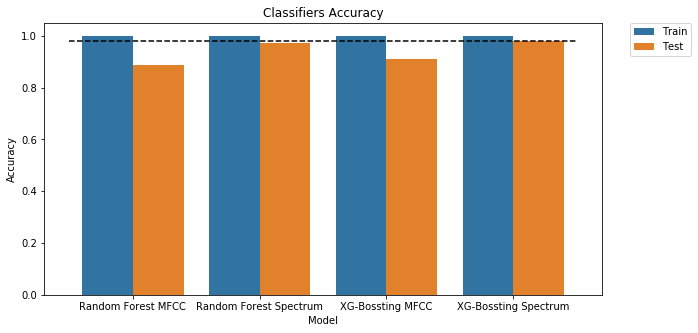

In [119]:
plt.figure(figsize=(10,5))
seaborn.barplot( x = 'Model',y = 'Accuracy', hue= 'Train-Test', data=acc)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
np.max(acc[acc['Train-Test'] == 'Test']['Accuracy'])
plt.hlines(y=np.max(acc[acc['Train-Test'] == 'Test']['Accuracy']), xmin= -0.5, xmax=3.5, linestyles ='dashed')
plt.title('Classifiers Accuracy')
print('XG-Bossting Spectrum Accuracy = %.3f' %np.max(acc[acc['Train-Test'] == 'Test']['Accuracy']))

## Predict one sample using spectrum

In [15]:
def predict_one_sample(filename):
    N_FFT = int(input('What is the N_FFT? [512]: '))
    S_store = []
    S,_ = read_audio_spectrum(filename,N_FFT = N_FFT)
    S_store.append(S)
    label = input('What is the label?: ')
    new_instrument = np.array(S_store)
    new_instrument = new_instrument.reshape(new_instrument.shape[0],-1) # I know this is sloppy but I need to do it fast
    #Load model
    with open ('./classifiers/XG_mfcc', 'rb') as read:
        model = pickle.load(read) 
        read.close()
    predict_label = model.predict(new_instrument)
    predict_proba = model.predict_proba(new_instrument)
    print('The instrument is a %s, with a likelihood of %.3f' %(predict_label[0],np.max(predict_proba)) )  
    print('Probabilities ', *predict_proba)
    #Audio
    display(Audio(filename,rate=8000) )  #display audio
    #figure
    plt.figure(figsize=(10,4), dpi= 200)
    plt.title(label)
    plt.imshow(S) #400 is tha maximum frequency range we want to plot. The matrix goes from 0 to 1000
    plt.ylabel('Freq(Hz)')
    plt.xlabel('Samples')
    plt.show()

In [57]:
def predict_mfcc(filename):
    N_FFT = int(input('What is the N_FFT? [512]: '))
    S_store = []
    S,_ = read_audio_spectrum(filename,N_FFT = N_FFT)
    S_store.append(S)
    M = get_features(filename)
    label = input('What is the label?: ')
    
    train_features = np.zeros((1,len(M)))
    train_features = M.reshape(1, -1)

    with open ('./classifiers/XG_mfcc', 'rb') as read:
        model = pickle.load(read) 
        read.close()
    predict_label = model.predict(train_features)
    predict_proba = model.predict_proba(train_features)
    print('The instrument is a %s, with a likelihood of %.3f' %(predict_label[0],np.max(predict_proba)) )  
    print('Probabilities ', *predict_proba)
    #Audio
    display(Audio(filename,rate=8000) )  #display audio
    #figure
    plt.figure(figsize=(10,4), dpi= 0)
    plt.title(label)
    plt.imshow(S) #400 is tha maximum frequency range we want to plot. The matrix goes from 0 to 1000
    plt.ylabel('Freq(Hz)')
    plt.xlabel('Samples')
    plt.show()

In [58]:
predict_mfcc('./flute_to_organ_000-031-025.wav')

What is the N_FFT? [512]:  512
What is the label?:  2


The instrument is a organ_electronic, with a likelihood of 0.999
Probabilities  [4.4985987e-05 9.9940276e-01 5.5220793e-04]


C:\Users\joaqu\Anaconda3\lib\site-packages\matplotlib\axis.py:2153: RuntimeWarning: invalid value encountered in double_scalars
  length = ((ends[1][0] - ends[0][0]) / self.axes.figure.dpi) * 72


ValueError: cannot convert float NaN to integer

# Training MFCC for 21 classes

## Getting training samples

In [60]:
S_store = []
no_classes = [] #the classes that do not have enough samples
Mel_store = []
train_labels = []
train_pitch = []
for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/train') #lift all the files in the path
    if len(instrument_path) < 375: 
        print('%s %d'% (instrument, len(instrument_path)))
        no_classes.append(instrument)
        continue
    for inst_path in instrument_path:
        train_labels.append(instrument)
        train_pitch.append(int(inst_path.split('_')[-1].split('-')[1])) #get the pitch 
        #S, fs = read_audio_spectrum(path+instrument+'/train/'+inst_path)
        M = get_features(path+instrument+'/train/'+inst_path)
        #S_store.append(S)
        Mel_store.append(M)

bass_acoustic 150
brass_electronic 52
brass_synthetic 0
flute_electronic 26
organ_acoustic 132
organ_synthetic 0
reed_electronic 57
string_electronic 63
string_synthetic 0
synth_lead_acoustic 0
synth_lead_electronic 0
vocal_electronic 105


In [61]:
# MAKING A LIST OF THE FINAL INSTRUMENT WE USED
classes = list(set(instruments) - set(no_classes))
final_inst = [ins for ins in classes]
final_inst.sort()
final_inst

['bass_electronic',
 'bass_synthetic',
 'brass_acoustic',
 'flute_acoustic',
 'flute_synthetic',
 'guitar_acoustic',
 'guitar_electronic',
 'guitar_synthetic',
 'keyboard_acoustic',
 'keyboard_electronic',
 'keyboard_synthetic',
 'mallet_acoustic',
 'mallet_electronic',
 'mallet_synthetic',
 'organ_electronic',
 'reed_acoustic',
 'reed_synthetic',
 'string_acoustic',
 'synth_lead_synthetic',
 'vocal_acoustic',
 'vocal_synthetic']

In [211]:
#Saving the matrix
with open('./Matrix/FULL_MFCC_matrix_train', 'wb') as write:
    pickle.dump(Mel_store, write)
with open('./Matrix/FULL_train_labels', 'wb') as write:
    pickle.dump(train_labels, write)    

## Getting Test samples

In [59]:
S_store_test = []
Mel_store_test = []
test_labels = []
test_pitch = []
no_classes_test = []

for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/test') #lift all the files in the path
    if len(instrument_path) < 125:  #125  test cases 
        print('%s %d'% (instrument, len(instrument_path)))
        no_classes_test.append(instrument)
        continue
    for inst_path in instrument_path:
        test_labels.append(instrument)
        test_pitch.append(int(inst_path.split('_')[-1].split('-')[1])) #get the pitch 
        #S, fs = read_audio_spectrum(path+instrument+'/test/'+inst_path)
        M = get_features(path+instrument+'/test/'+inst_path)
        #S_store.append(S)
        Mel_store_test.append(M)

bass_acoustic 50
brass_electronic 18
brass_synthetic 0
flute_electronic 9
organ_acoustic 44
organ_synthetic 0
reed_electronic 19
string_electronic 21
string_synthetic 0
synth_lead_acoustic 0
synth_lead_electronic 0
vocal_electronic 35


In [210]:
#Saving the matrix
with open('./Matrix/FULL_MFCC_matrix_test', 'wb') as write:
    pickle.dump(Mel_store_test, write)
with open('./Matrix/FULL_test_labels', 'wb') as write:
    pickle.dump(test_labels, write)    

In [ ]:
#Loading
with open ('./classifiers/FULL_MFCC_matrix_test', 'rb') as read:
    Mel_store_test = pickle.load(read) 
    read.close()
with open ('./classifiers/FULL_test_labels', 'rb') as read:
    test_labels = pickle.load(read) 
    read.close()

In [25]:
no_classes == no_classes_test #sanity check. 

True

In [62]:
train_features = np.zeros((len(Mel_store),len(Mel_store[0])))
for n,i in enumerate(Mel_store):
    train_features[n] = i

test_features = np.zeros((len(Mel_store_test),len(Mel_store_test[0])))
for n,i in enumerate(Mel_store_test):
    test_features[n] = i

In [219]:
# Modeling XG with MFCC for different classes
import xgboost as xgb
XG = xgb.XGBClassifier(max_depth=3, booster='gbtree', n_estimators=200, learning_rate=0.1)
XG.fit(train_features, train_labels)
#Save model
with open('./classifiers/FULL_XG_Mfcc', 'wb') as write:
    pickle.dump(XG, write)

    

In [65]:
with open ('./classifiers/FULL_XG_Mfcc', 'rb') as read:
    XG = pickle.load(read) 
    read.close()
#Predict Training
train_classif_predictions = XG.predict(train_features)  
xg_train_accuracy_mfcc = accuracy_score(train_labels,train_classif_predictions,normalize=True)
print('Accuracy clasification Training = %.3f' % xg_train_accuracy_mfcc)
#Predicting Testing
classif_predictions = XG.predict(test_features)
xg_accuracy_mfcc= accuracy_score(test_labels, classif_predictions,normalize=True)
print('Accuracy clasification Testing = %.3f' %  xg_accuracy_mfcc )
f1 = f1_score(test_labels, classif_predictions, average='weighted')
print('F1: %.3f' %f1)

Accuracy clasification Training = 0.721
Accuracy clasification Testing = 0.434
F1: 0.413


Text(0.5, 51.0, 'Predicted Instrument')

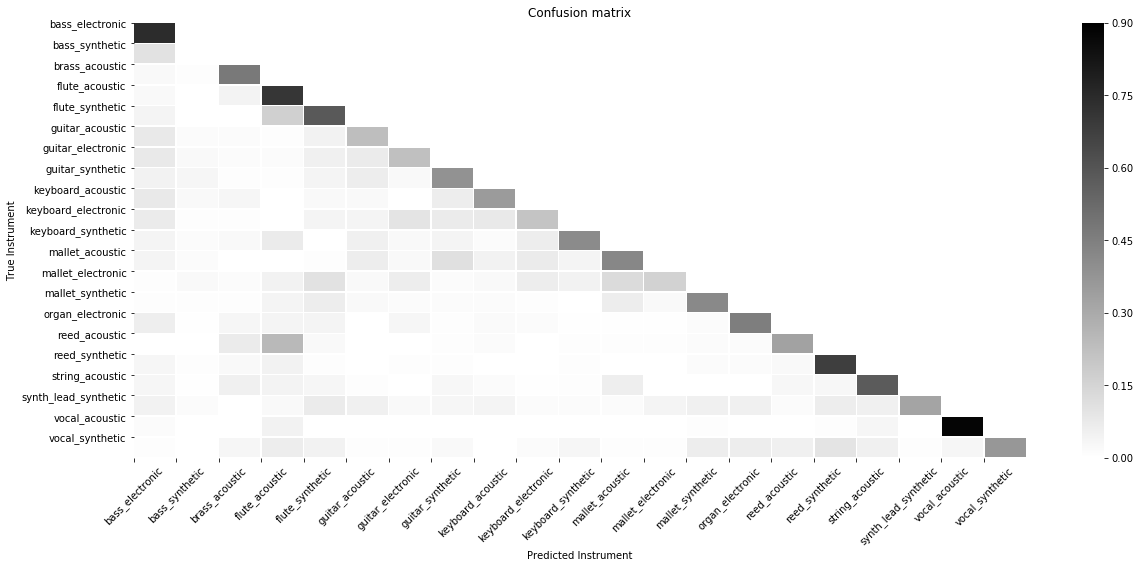

In [66]:
#Confusion Matrix
cm = confusion_matrix(test_labels, classif_predictions ,  labels=[inst for inst in final_inst])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = unique_labels(test_labels, classif_predictions)
plt.figure(figsize=(20,8))
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
for n,i in enumerate(mask):
    mask[n][n] = False
seaborn.heatmap(cm, mask = mask, cmap = 'binary', linewidths=.5,vmin=0, vmax=.9) #mask = mask,
plt.xticks(np.arange(cm.shape[1]),classes, rotation = 45)
plt.yticks(np.arange(cm.shape[0]),classes, rotation = 0)
plt.title('Confusion matrix')
plt.ylabel('True Instrument')
plt.xlabel('Predicted Instrument')

# Training Random Forest for Spectrum 21 classess

In [4]:
S_store = []
no_classes = [] #the classes that do not have enough samples
#Mel_store = []
train_labels = []
#train_pitch = []
for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/train') #lift all the files in the path
    if len(instrument_path) < 375: 
        print('%s %d'% (instrument, len(instrument_path)))
        no_classes.append(instrument)
        continue
    print('done')
    for inst_path in instrument_path:
        train_labels.append(instrument)
        #train_pitch.append(int(inst_path.split('_')[-1].split('-')[1])) #get the pitch 
        S, fs = read_audio_spectrum(path+instrument+'/train/'+inst_path, N_FFT= 512)
        #M = get_features(path+instrument+'/train/'+inst_path)
        S_store.append(S)
        #Mel_store.append(M)


bass_acoustic 150
done
done
done
brass_electronic 52
brass_synthetic 0
done
flute_electronic 26
done
done
done
done
done
done
done
done
done
done
organ_acoustic 132
done
organ_synthetic 0
done
reed_electronic 57
done
done
string_electronic 63
string_synthetic 0
synth_lead_acoustic 0
synth_lead_electronic 0
done
done
vocal_electronic 105
done


In [5]:
#Saving the matrix
with open('./Matrix/FULL_spectrum_train', 'wb') as write:
    pickle.dump(S_store, write)
with open('./Matrix/FULL_train_labels', 'wb') as write:
    pickle.dump(train_labels, write)    


In [28]:
#Loading the matrix
with open ('./Matrix/FULL_spectrum_train', 'rb') as read:
    S_store = pickle.load(read)
with open ('./Matrix/FULL_train_labels', 'rb') as read:
    train_labels = pickle.load(read)    

In [33]:
S_store_test = []
#Mel_store_test = []
test_labels = []
#test_pitch = []
no_classes_test = []

for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/test') #lift all the files in the path
    if len(instrument_path) < 125:  #125  test cases 
        print('%s %d'% (instrument, len(instrument_path)))
        no_classes_test.append(instrument)
        continue
    print('done')
    for inst_path in instrument_path[:1]:
        test_labels.append(instrument)
        #test_pitch.append(int(inst_path.split('_')[-1].split('-')[1])) #get the pitch 
        S, fs = read_audio_spectrum(path+instrument+'/test/'+inst_path,N_FFT= 512)
        #M = get_features(path+instrument+'/test/'+inst_path)
        S_store_test.append(S)
        #Mel_store_test.append(M)
 

bass_acoustic 50
done
done
done
brass_electronic 18
brass_synthetic 0
done
flute_electronic 9
done
done
done
done
done
done
done
done
done
done
organ_acoustic 44
done
organ_synthetic 0
done
reed_electronic 19
done
done
string_electronic 21
string_synthetic 0
synth_lead_acoustic 0
synth_lead_electronic 0
done
done
vocal_electronic 35
done


In [8]:
#Saving the matrix
with open('./Matrix/FULL_spectrum_test', 'wb') as write:
    pickle.dump(S_store_test, write)
with open('./Matrix/FULL_test_labels', 'wb') as write:
    pickle.dump(test_labels, write)    

In [9]:
#Loading the matrix
with open ('./Matrix/FULL_spectrum_test', 'rb') as read:
    S_store_test = pickle.load(read)
with open ('./Matrix/FULL_test_labels', 'rb') as read:
    test_labels = pickle.load(read)    

In [10]:
train_features = np.array(S_store)
train_features = train_features.reshape(train_features.shape[0],-1)
test_features = np.array(S_store_test)
test_features = test_features.reshape(test_features.shape[0],-1)

In [13]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 10, oob_score= True) #min_impurity_decrease maybe too?
rf.fit(train_features, train_labels)
classif_predictions = rf.predict(test_features) 
#Predict test
classi_probe = rf.predict_proba(test_features)  
rf_test_accuracy_spectrum = accuracy_score(test_labels,classif_predictions,normalize=True)
#Predict Training
train_classif_predictions = rf.predict(train_features)  
rf_train_accuracy_spectrum = accuracy_score(train_labels,train_classif_predictions,normalize=True)

print('Accuracy clasification Training = %.3f' % rf_train_accuracy_spectrum)
f1 = f1_score(test_labels, classif_predictions, average='weighted') #Use labeled y-hat. Given that our classes present imbalance, we are going to use the weighted option;
print('Accuracy clasification Test = %.3f' % rf_test_accuracy_spectrum)
print('F1 score = %.3f' % f1)
print('OOB score = %.3f' %rf.oob_score_)


Accuracy clasification Training = 1.000
Accuracy clasification Test = 0.725
F1 score = 0.716
OOB score = 0.704


In [14]:
#Save the model
with open('./classifiers/Full_RF_spectrum', 'wb') as write:
    pickle.dump(rf, write)

In [15]:
#Load the model
with open ('./classifiers/Full_RF_spectrum', 'rb') as read:
    rf = pickle.load(read)   

In [35]:
# MAKING A LIST OF THE FINAL INSTRUMENT WE USED
classes = list(set(instruments) - set(no_classes_test))
final_inst = [ins for ins in classes]
final_inst.sort()
final_inst
#print(no_classes == no_classes_test) #sanity check. )

['bass_electronic',
 'bass_synthetic',
 'brass_acoustic',
 'flute_acoustic',
 'flute_synthetic',
 'guitar_acoustic',
 'guitar_electronic',
 'guitar_synthetic',
 'keyboard_acoustic',
 'keyboard_electronic',
 'keyboard_synthetic',
 'mallet_acoustic',
 'mallet_electronic',
 'mallet_synthetic',
 'organ_electronic',
 'reed_acoustic',
 'reed_synthetic',
 'string_acoustic',
 'synth_lead_synthetic',
 'vocal_acoustic',
 'vocal_synthetic']

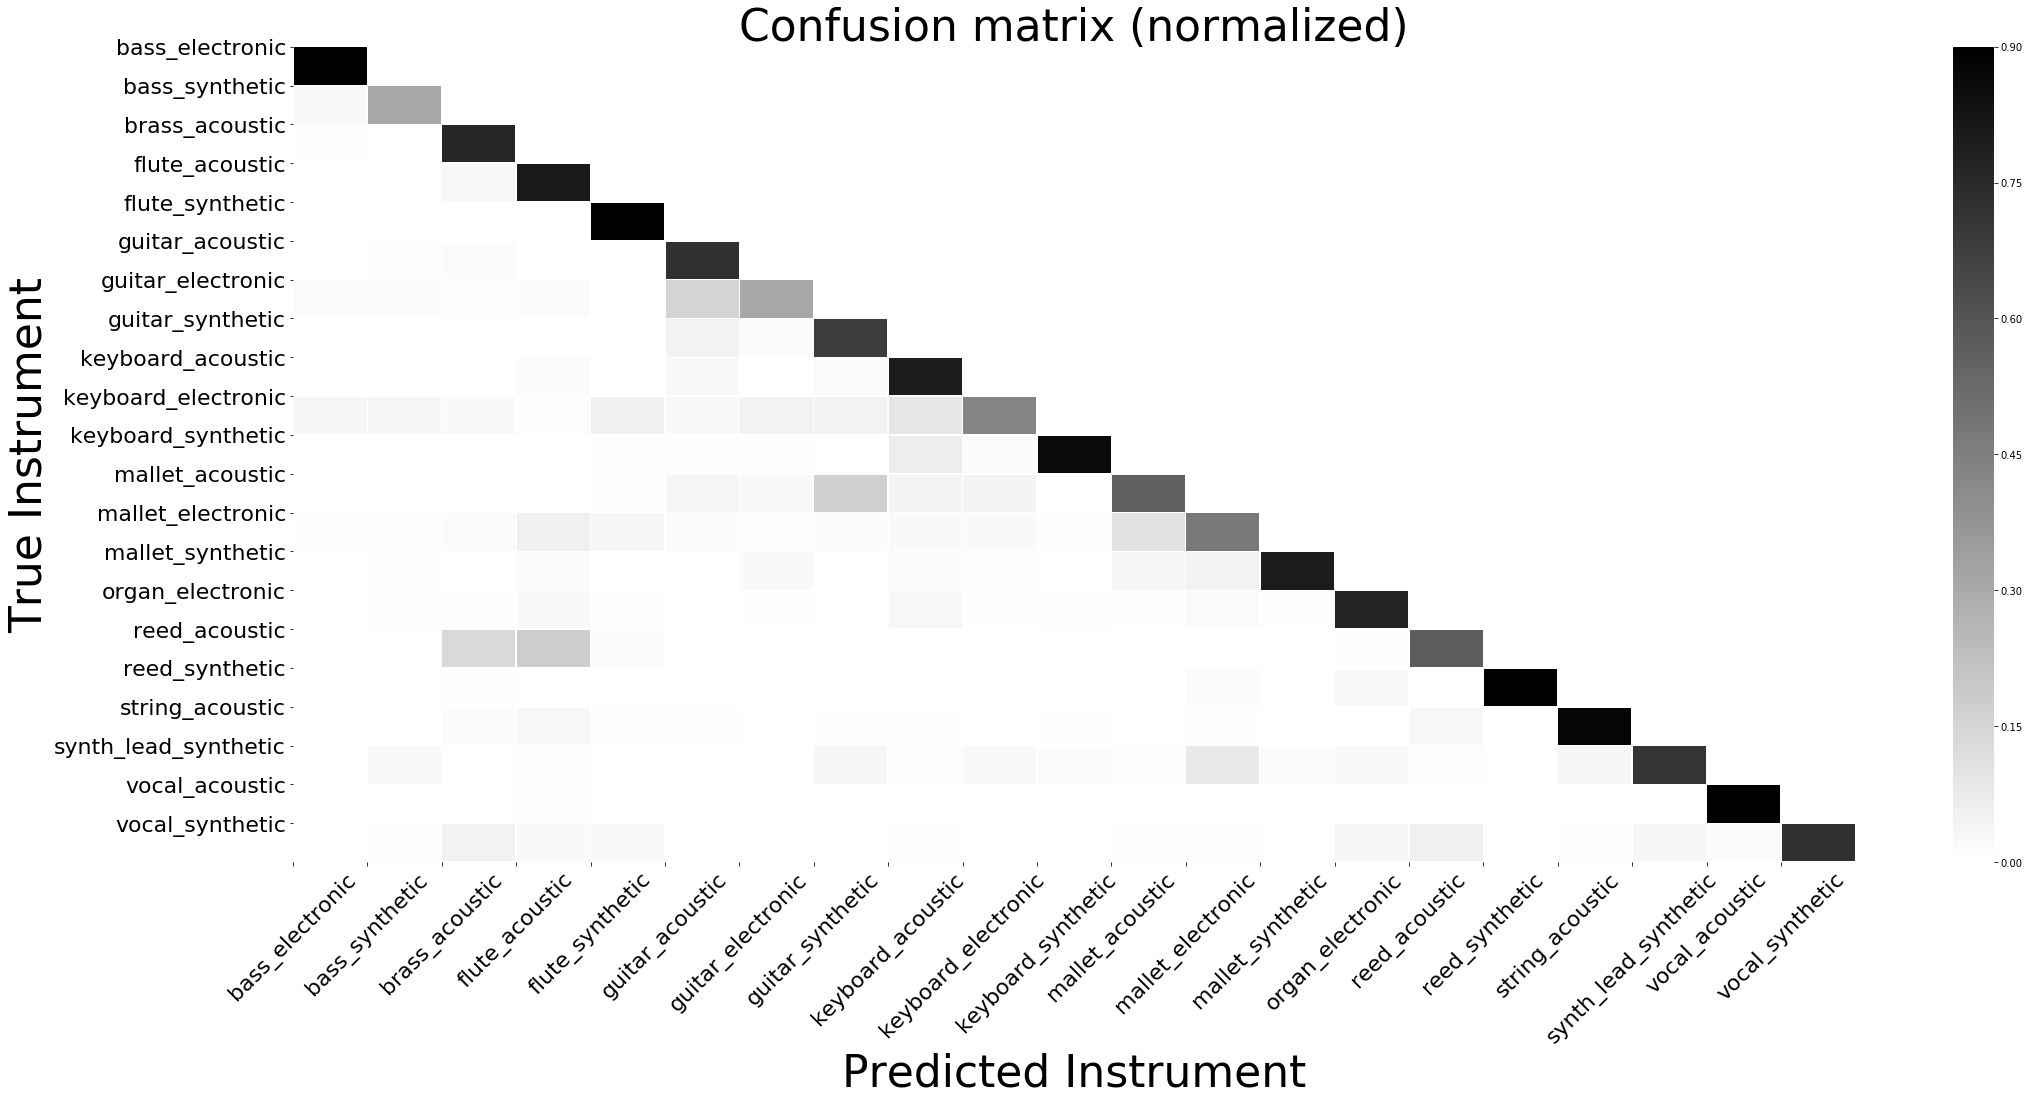

In [17]:
# MAKING A LIST OF THE FINAL INSTRUMENT WE USED
classes = list(set(instruments) - set(no_classes_test))
final_inst = [ins for ins in classes]
final_inst.sort()
final_inst
print(no_classes == no_classes_test) #sanity check. )

## XG Boosting

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_validate, train_test_split
XG = xgb.XGBClassifier(max_depth=3, booster='gbtree', n_estimators=200, learning_rate=0.1)
XG.fit(train_features, train_labels)
#Save model
with open('./classifiers/XG_spectrum', 'wb') as write:
    pickle.dump(XG, write)
    
#Predict Training
train_classif_predictions = XG.predict(train_features)  
xg_train_accuracy_spectrum = accuracy_score(train_labels,train_classif_predictions,normalize=True)
print('Accuracy clasification Training = %.3f' % xg_train_accuracy_spectrum)

#Predicting Testing
classif_predictions = XG.predict(test_features)
xg_accuracy_spectrum= accuracy_score(test_labels, classif_predictions,normalize=True)
print('Accuracy clasification Testing = %.3f' %  xg_accuracy_spectrum)

In [ ]:
with open('./Matrix/FULL_XGBoosting_Spectrum', 'wb') as write:
    pickle.dump(XG, write)